[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab9_transfer_learning.ipynb)

# Transfer Learning/Fine-Tuning

During training, neural networks often learn features that are useful for a wide variety of tasks. For example, the earliest layers of convolution networks often learn very basic visual features, such as edge detection. These task-agnostic features can be very useful when applied to other tasks. Transfer learning or fine-tuning is a technique that takes a network pretrained on one task and trains it on another. The idea is to tweak or tune the parameters on the new task, rather than making huge changes in learning. Fine-tuning is often quicker than learning on the new task from scratch, and can even lead to better overall performance and generalization.

Unfreezing a pretrained network is a fine-tuning technique that can be helpful when training a network on a difficult task with limited data.
If we allow the network to train its earliest layers immediately, then the earliest layers will forget all of the useful task-agnostic features they learned previously. So, rather than training all of the model weights at once, we learn on the last few layers (which are the most task-specific in the network). We can also gradually start training on the earlier layers as training progresses.

In this lab, you will compare unfreezing fine-tuning techniques against training a model from scratch. You will use the large ResNet-152 model to learn the small Bird Species Classification dataset.


### Grading

- 20% Analyze Dataset
- 20% Implementing `BirdNet`
- 20% Implementing `train()`
- 30% Running finetuning experiment
- 10% Answering questions


In [1]:
import zipfile
import os
import sys
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import time
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda")

## Analyze `BirdDataset`

Start by first downloading the dataset from Kaggle.

#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab.

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [3]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 64 Nov 17 06:39 kaggle.json


3. Copy the desired dataset locally

In [4]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
!kaggle datasets download -d akash2907/bird-species-classification

Dataset URL: https://www.kaggle.com/datasets/akash2907/bird-species-classification
License(s): CC-BY-NC-SA-4.0
100% 1.37G/1.37G [00:48<00:00, 29.6MB/s]
100% 1.37G/1.37G [00:48<00:00, 30.2MB/s]


The `BirdDataset` is implemented for you below. Instantiate a `train_dataset` and `val_dataset`.

In [5]:
class BirdDataset(Dataset):
    def __init__(self, zip_file='bird-species-classification.zip', size=256, train=True, upload=False):
        super(BirdDataset, self).__init__()

        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # We resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'

        if train:
            # The bird-species dataset mistakenly has a train_data folder inside of train_data
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)
                else:
                    print(f"else {name}")

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

In [6]:
train_dataset = BirdDataset(train=True)
val_dataset = BirdDataset(train=False)

Extracting bird-species-classification.zip
Resizing images


Print out the number of instances of each class in the `train_dataset` and `val_dataset`.

In [7]:
from pprint import pprint

classes_to_indices = val_dataset.dataset_folder.class_to_idx
indices_to_classes = {v: k for k, v in classes_to_indices.items()}

instance_count = {}
for image in train_dataset.dataset_folder.imgs:
    class_index = image[1]
    class_name = indices_to_classes[class_index]

    if class_name in instance_count:
        instance_count[class_name] += 1
    else:
        instance_count[class_name] = 1

pprint(instance_count)

{'blasti': 15,
 'bonegl': 6,
 'brhkyt': 5,
 'cbrtsh': 7,
 'cmnmyn': 7,
 'gretit': 6,
 'hilpig': 10,
 'himbul': 18,
 'himgri': 20,
 'hsparo': 9,
 'indvul': 9,
 'jglowl': 6,
 'lbicrw': 6,
 'mgprob': 6,
 'rebimg': 10,
 'wcrsrt': 10}


Print out a single image for each class in a 4x4 display.

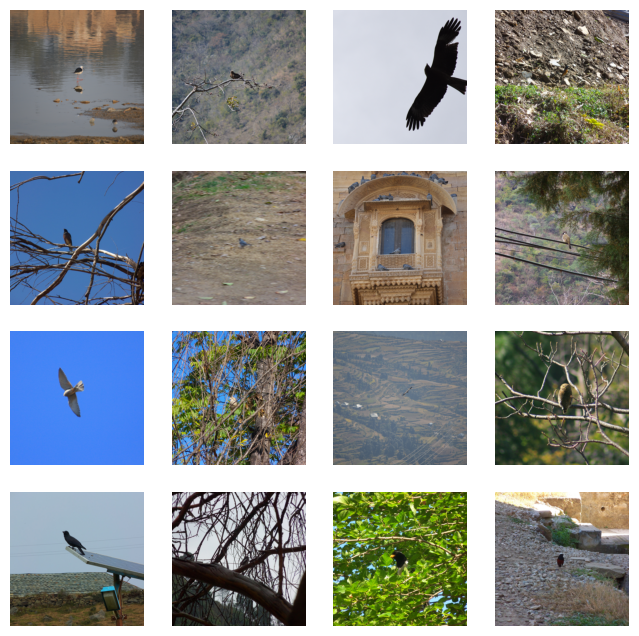

In [8]:
printed_classes = {index: False for index, _ in indices_to_classes.items()}

images = []
for image in train_dataset.dataset_folder.imgs:
    class_index = image[1]
    if not printed_classes[class_index]:
        images.append(image)

        printed_classes[class_index] = True
        if all(printed_classes.values()):
            break

figure, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()
for i, image in enumerate(images):
    img = Image.open(image[0])
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

You will notice that not only do we have a small training dataset (150 images), some of the images are potentially difficult to classify because of how small the bird appears in the image. If you investigated the images further you would notice that many images of a given class are subsequent snapshots of the same bird. This will make generalization hard and overfitting easy, especially with a large network.

## Implement `BirdNet`


Implement the `BirdNet`: a wrapper class adding functionality to a (pretrained) `ResNet`.

### Implement `__init__()`
- The `BirdNet` should first instantiate a `models.resnet152` object and optionally, load in pretrained weights (look at https://pytorch.org/vision/stable/models.html for more information about using pretrained weights). We suggest using `models.ResNet152_Weights.IMAGENET1K_V1`.
- Overwrite the final layer in the ResNet to linearly map (with `nn.Linear`) the previous layers features to `n_classes`.
- Freeze all weights except the final layer. You can do this with calling `.requires_grad = False` on the parameters or calling `.requires_grad(False)` on the layers.


### Implement `unfreeze()`
Implement `unfreeze()` to unfreeze the last `n_layers` of your model. Do not treat the sequential or bottleneck layers in the ResNet as a single layer; we consider a convolutional layer or linear layer as a single layer. You may optionally treat a batchnorm layer as its own layer or as part of a conv/linear layer. ReLU layers do not have parameters, so they can't be frozen/unfrozen.


**Tip**: *You can print out a `models.resnet152` object to get an idea of how many input features are used in the last layer as well as the structure and naming convention used by the ResNet to know how to unfreeze `n_layers`.*


Create a temporary resnet152 model and print it here to see the structure of the network and the naming conventions. You can iterate over `.named_parameters()` to get the name and parameter object, respectively, to verify the naming scheme. This function can make your unfreezing function simpler.

In [9]:
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 159MB/s]


In [10]:
# pprint(model)

In [11]:
# for name, param in model.named_parameters():
#     print(name)

In [22]:
class BirdNet(nn.Module):
    def __init__(self, n_classes, pretrained_weights):
        super().__init__()
        self.net = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

        num_final_inputs = self.net.fc.in_features
        self.net.fc = nn.Linear(num_final_inputs, n_classes)

        self.parameters = [param for _, param in self.net.named_parameters()]

        for param in self.parameters:
            param.requires_grad = False

    def unfreeze(self, n_layers):
        if n_layers < 0: # Unfreeze all the layers
            n_layers = len(self.parameters)

        for i in range(n_layers):
            self.parameters[-i - 1].requires_grad = True

    def forward(self, x):
        return self.net(x)

## Training

In [13]:
@torch.no_grad()
def accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc.item()


@torch.no_grad()
def evaluate(model, loss_fn, val_loader):
    val_losses = 0
    val_accs = 0
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()

    for x, y_truth in val_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        val_losses += loss_fn(y_hat, y_truth).item() * len(x)
        val_accs += accuracy(y_hat, y_truth) * len(x)

    model.train()
    return val_losses/len(val_dataset), val_accs/len(val_dataset)


Implement the `train()` function. Keep track of the usual performance metrics (training/validation losses and accuracies) and additionally keep track of how long, in seconds, training took (this is referred to as wallclock training time).

There are two additional arguments in `train()`: `slowly_unfreeze` and `unfreeze_interval`.
 If `slowly_unfreeze=True` then for every `unfreeze_interval` number of steps you should unfreeze an additional layer from your model.

In [14]:
def train(model, optimizer, n_optimization_steps, log_interval, slowly_unfreeze, unfreeze_interval):
    start_time = time.time()

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)
    loss_fn = nn.CrossEntropyLoss()

    losses = []
    accuracies = []
    validation_losses = []
    validation_accuracies = []

    for i in range(n_optimization_steps):
        x, y = next(iter(train_loader))
        x = x.to(device)
        y = y.to(device)

        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        acc = accuracy(y_hat, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        accuracies.append(acc)

        if i % log_interval == 0:
            val_loss, val_acc = evaluate(model, loss_fn, val_loader)
            validation_losses.append(val_loss)
            validation_accuracies.append(val_acc)

        if slowly_unfreeze and i % unfreeze_interval == 0:
            model.unfreeze(1)

    end_time = time.time()
    wallclock_time = end_time - start_time

    return losses, accuracies, validation_losses, validation_accuracies, wallclock_time

To compare how well finetuning works you will perform a set of experiments. There are four models you will train for `n_trials >= 3`:
- `res-reinit`: A reinitialized (not pretrained) resnet model. This is the baseline.
- `res1`: A pretrained resnet model with only the last layer unfrozen.
- `res3`: A pretrained resnet model with the last 3 layers unfrozen.
- `res10-slow`: A pretrained resnet model with the last last 10 layers **slowly** unfrozen.

For each model average the results across the `n_trials` and plot the val accuracy across time for each model and print out the average wallclock time and time per optimization step (i.e. wallclock_time / optimization_step) . **Do not forget to recreate the model and optimizer between each trial.**


**Tip:** Make sure everything is implemented correctly before running all `n_trials` on all four models. We found that a learning rate of .001 worked well for 100 optimization steps.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model: res_reinit


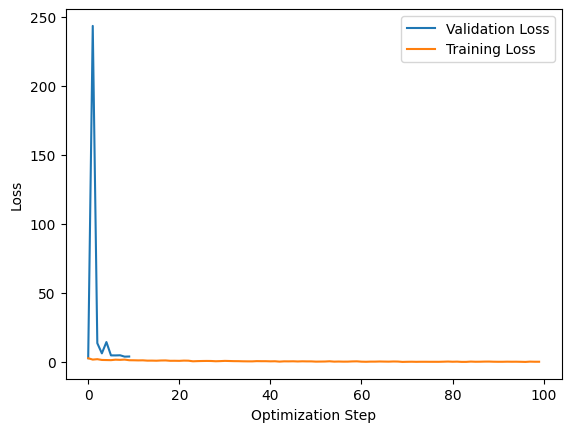

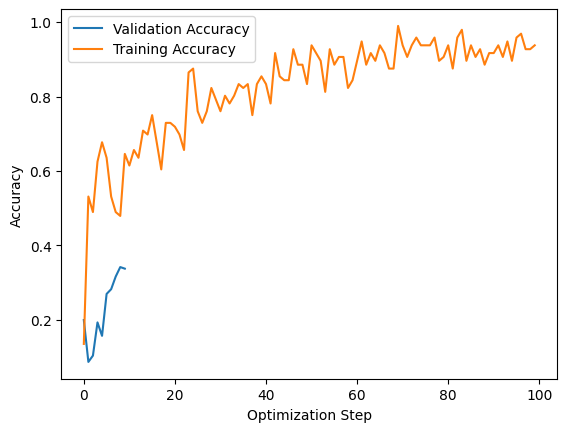

Average wallclock time: 148.36603132883707
Average time per step: 1.4836603132883708


In [24]:
training_models = ["res_reinit"]
# models = ["res_reinit", "res1", "res3", "res10_slow"]

n_trials = 3
n_optimization_steps = 100
log_interval = 10
unfreeze_interval = 10

for model_name in training_models:
    n_classes = len(train_dataset.dataset_folder.classes)
    pretrained_weights = models.ResNet152_Weights.IMAGENET1K_V1
    n_unfreeze_layers = 0
    slowly_unfreeze = False

    if model_name == "res_reinit":
        n_unfreeze_layers = -1
        pretrained_weights = None
    elif model_name == "res1":
        n_unfreeze_layers = 1
    elif model_name == "res3":
        n_unfreeze_layers = 3
    elif model_name == "res10_slow":
        n_unfreeze_layers = 10
        slowly_unfreeze = True

    losses = []
    accuracies = []
    validation_losses = []
    validation_accuracies = []
    wallclock_times = []

    for _ in range(n_trials):
        model = BirdNet(n_classes, pretrained_weights)
        model.to(device)
        model.unfreeze(n_unfreeze_layers)

        optimizer = torch.optim.Adam(model.parameters, lr=0.001)

        loss, acc, val_loss, val_acc, wallclock_time = train(
            model, optimizer, n_optimization_steps, log_interval, slowly_unfreeze, unfreeze_interval
        )

        losses.append(loss)
        accuracies.append(acc)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)
        wallclock_times.append(wallclock_time)

    print(f"Model: {model_name}")

    average_losses = [sum(loss_list) / len(loss_list) for loss_list in zip(*losses)]
    average_val_losses = [sum(loss_list) / len(loss_list) for loss_list in zip(*validation_losses)]

    plt.plot(average_val_losses, label="Validation Loss")
    plt.plot(average_losses, label="Training Loss")
    plt.xlabel("Optimization Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    average_accuracies = [sum(acc_list) / len(acc_list) for acc_list in zip(*accuracies)]
    average_val_accuracies = [sum(acc_list) / len(acc_list) for acc_list in zip(*validation_accuracies)]

    plt.plot(average_val_accuracies, label="Validation Accuracy")
    plt.plot(average_accuracies, label="Training Accuracy")
    plt.xlabel("Optimization Step")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    average_wallclock_time = sum(wallclock_times) / len(wallclock_times)
    average_time_per_step = average_wallclock_time / n_optimization_steps

    print(f"Average wallclock time: {average_wallclock_time}")
    print(f"Average time per step: {average_time_per_step}")


### Questions
- Which model performed the best?
- How do the finetuned models compare to the reinitialized model in terms of time?
  - **Because fewer layers are trained, less training time is required.**
- Why are the ImageNet weights helpful to learning the Bird dataset?
  - **There's not enough data in the training set in order to learn abstract image features, like edges. The pre-trained ImageNet model has already learned these abstract features in its lower layers.**
- Why do we only unfreeze the last few layers?
  - **The last layers are the layers that learn non-abstract details, like color and basic shape.**
- What are some pros and cons of pretraining?
  - **Pro: a useful model for a niche task can be trained with a smaller dataset**
  - **Con: the pretrained model may not be optimal for the task we are training for, and may even inhibit the model's learning.**
